In [1]:
#!pip3 install neat-python
import os
from tensorflow.keras.datasets import mnist
import numpy as np
import ssl
import neat
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pickle
import csv
import ssl
import cv2
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

## Global Parameters

In [2]:
# Dataset parameters
DATASET = "MNIST"
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = (16,16)
N_CLASSES_TO_USE = 10

# How many samples to test:
N_SAMPLES_TO_TEST = 200

# Simulation Parameters
NR_GENERATIONS =1000
CONFIG_FILE = 'NEAT-configs/mnist-wann'

## Load MNIST

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

## Preprocess MNIST

In [4]:
def preprocess(samples, size, n_samples, unskew=True):
    # Create list of processed images
    processed  = np.empty((n_samples,size[0],size[1]))

    # Unskew and resize
    if unskew == True:    
        for i in range(n_samples):
            processed[i,:,:] = deskew(cv2.resize(samples[i,:,:],size),size)
    return processed

def deskew(image, image_shape, negated=True):
    """ source: https://github.com/vsvinayak/mnist-helper """
  
    # negate the image
    if not negated:
        image = 255-image
    
    # calculate the moments of the image
    m = cv2.moments(image)
    if abs(m['mu02']) < 1e-2:
        return image.copy()
    
    # caclulating the skew
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*image_shape[0]*skew], [0,1,0]])
    img = cv2.warpAffine(image, M, image_shape, flags=cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR)  
    return img

n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]

# Rescale and preprocess training and testing data
X_train_processed = preprocess(X_train/255, DESIRED_IMAGE_SIZE, n_samples_train)
X_test_processed = preprocess(X_test/255, DESIRED_IMAGE_SIZE, n_samples_test)
    
    

##### WRAPPING UP #####
    
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_processed.reshape(n_samples_train, np.prod(DESIRED_IMAGE_SIZE))
X_test = X_test_processed.reshape(n_samples_test, np.prod(DESIRED_IMAGE_SIZE))

### Visualize

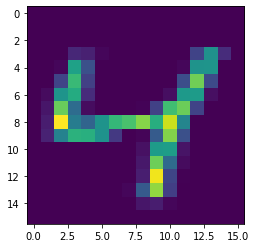

In [5]:
plt.imshow(X_train_processed[2])

# NEAT

## Basic Run Function

In [6]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

# def sigmoid(output):
#     output = [min(709., x) for x in output]
#     output = [max(-709., x) for x in output]
#     return [1 /(1 + exp(-x)) for x in output]

def softmax(output):
    e = exp(output)
    return e / e.sum()

In [7]:
def step(x):
    return 1.0*(x>0.0)

def wann_cos(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return math.cos(math.pi*x)
    
def wann_sin(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return math.sin(math.pi * x)
        
def wann_sigmoid(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return (math.tanh(x/2.0) + 1.0)/2.0

def wann_inverse(x):
    return -x

def wann_gauss(x):
    x = max(-3.4, min(3.4, x))
    return exp(- (x*x) / 2.0)
        

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    config.genome_config.add_activation('step', step)
    config.genome_config.add_activation('wcos', wann_cos)
    config.genome_config.add_activation('wsin', wann_sin)
    config.genome_config.add_activation('wsig', wann_sigmoid)
    config.genome_config.add_activation('winv', wann_inverse)
    config.genome_config.add_activation('wgauss', wann_gauss)
    
    
    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(50, filename_prefix='NEAT-checkpoints/neat-checkpoint-10-classes-'))
    
    
    # Run for up to NR_GENERATIONS generations.
    winner = p.run(eval_genomes, NR_GENERATIONS)
    stats.save_genome_fitness(filename="NEAT-results/fitness_history.csv")
    stats.save_species_count(filename="NEAT-results/species_count.csv")
    with open('NEAT-results/best_genomes', 'wb') as f:
        best_genomes = stats.best_genomes(10)
        pickle.dump(best_genomes,f)
    
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))


## Basic Evaluation Function

In [8]:
def eval_genomes(genomes, config):
    
    def _cross_entropy(pred, label):
        return -np.log(exp(pred[label])/np.sum(exp(pred), axis=0))
    
    sample_indices = []
    n_samples_per_class = int(N_SAMPLES_TO_TEST/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        
    nr_nodes = 0
    nr_connections = 0
    for genome_id, genome in genomes:
        nr_nodes +=len(genome.nodes)
        nr_connections +=len(genome.connections)
        
        
        ce = []
        
        genome.fitness = 0.
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nr_correct = 0.
        for i in sample_indices:
            train, label = X_train[i], Y_train[i]
            output = softmax(net.activate(train))
            
            ce.append(-_cross_entropy(output, label))
#             if np.argmax(sigmoid(output)) == label:
#                 nr_correct += 1.

        genome.fitness = np.average(ce) 
    
    avg_nodes = nr_nodes / float(len(genomes))
    avg_connections = nr_connections / float(len(genomes))
    with open("NEAT-results/sizes_mnist.csv",'a', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([avg_nodes, avg_connections])
    

In [ ]:
run(CONFIG_FILE)


 ****** Running generation 0 ****** 

Population's average fitness: -2.30933 stdev: 0.01471
Best fitness: -2.27142 - size: (10, 128) - species 1 - id 92
Average adjusted fitness: 0.043
Mean genetic distance 2.314, standard deviation 0.275
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   250     -2.3    0.043     0
Total extinctions: 0
Generation time: 10.859 sec

 ****** Running generation 1 ****** 

Population's average fitness: -2.30258 stdev: 0.01649
Best fitness: -2.26483 - size: (11, 128) - species 1 - id 472
Average adjusted fitness: 0.061
Mean genetic distance 2.030, standard deviation 0.738
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   250     -2.3    0.061     0
Total extinctions: 0
Generation time: 10.948 sec (10.904 average)

 ****** Running generation 2 ****** 

Population's average fitness: -2.

## Plot History

In [ ]:
history = np.genfromtxt('NEAT-results/fitness_history.csv', delimiter='')
best_fitness = history[:,0]
avg_fitness = history[:,1]

In [ ]:
plt.plot(best_fitness, label = 'Best Fitness')
plt.plot(avg_fitness, label = 'Average Fitness')
plt.title('Best and Average Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness (Negative Cross Entropy)')
plt.legend()
plt.show()

## Plot Sizes over Generations

In [ ]:
sizes = np.genfromtxt('NEAT-results/sizes_mnist.csv', delimiter='')
avg_nodes = sizes[:,0]
avg_connections = sizes[:,1]

In [ ]:
plt.plot(avg_nodes)
plt.title('Average Nodes per Generation')
plt.xlabel('Generation')
plt.ylabel('Nr of Nodes')
plt.show()

In [ ]:
plt.plot(avg_connections)
plt.title('Average Connections per Generation')
plt.xlabel('Generation')
plt.ylabel('Nr of Connections')
plt.show()

## Load and Test Fittest Member

In [ ]:
def test_fittest(config_file):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    config.genome_config.add_activation('step', step)
    config.genome_config.add_activation('wcos', wann_cos)
    config.genome_config.add_activation('wsin', wann_sin)
    config.genome_config.add_activation('wsig', wann_sigmoid)
    config.genome_config.add_activation('winv', wann_inverse)
    config.genome_config.add_activation('wgauss', wann_gauss)
    preds_test = []
    preds_train = []
    train_correct = 0.
    test_correct = 0. 
    fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]
    #print(fittest_genome)
    net = neat.nn.FeedForwardNetwork.create(fittest_genome, config)
        
    for train, label in zip(X_train, Y_train):
        output = np.argmax(softmax(net.activate(train)))
        preds_train.append(output)
        if output == label:
            train_correct += 1.
    train_acc = train_correct / len(X_train)
    
    for test, label in zip(X_test, Y_test):
        output = np.argmax(softmax(net.activate(test)))
        preds_test.append(output)
        if output == label:
            test_correct += 1.
    test_acc = test_correct / len(X_test)
        
    print("Train Accuracy = {}".format(train_acc))
    print("Test Accuracy = {}".format(test_acc))
    
    return preds_train, preds_test

In [ ]:
preds_train, preds_test = test_fittest(CONFIG_FILE)

In [ ]:
cm_train = confusion_matrix(Y_train, preds_train, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, preds_test, labels=range(N_CLASSES_TO_USE))

In [ ]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for test data')

# Show the result
plt.show()

## Inspecting Fittest Genome

In [ ]:
fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]

In [ ]:
print(fittest_genome)

In [ ]:
used_input_pixels = []
for cg in fittest_genome.connections.values():
    if cg.enabled:
        used_input_pixels.append(cg.key[0])
print(used_input_pixels)

In [ ]:
input_tallies = np.zeros(X_train.shape[1])
for arg in used_input_pixels:
    if arg <0:
        input_tallies[arg] += 1
plt.imshow( input_tallies.reshape(16,16) )
plt.title('Used Input Pixels')
plt.axis('off')
plt.show()